In [1]:
import tensorflow as tf
import tensorflow_compression as tfc
import numpy as np
import matplotlib.pyplot as plt
from time import time

import os

2023-02-27 12:54:34.992254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 12:54:35.115275: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-27 12:54:35.759725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-27 12:54:35.759809: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
N_GPUS = 2

gpus = tf.config.list_physical_devices('GPU')

if N_GPUS == 1:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    
visible_gpus = tf.config.get_visible_devices()

visible_gpus

2023-02-27 12:54:59.165356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:54:59.168648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:54:59.206744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:54:59.209665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:54:59.212559: I tensorflow/compiler/xla/stream_executo

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_stl10_dataset(data_path, batch_size=32, norm=False, verbose=False):
    with open(data_path, 'rb') as f:
        
        if verbose:
            print("Reading data from {}".format(data_path))
        t0 = time()
        
        X = np.fromfile(f, dtype=np.uint8)
        
        t = time() - t0
        if verbose:
            print(f"Read data from {data_path} in {t:.2f} seconds")
        
        X = np.reshape(X, (-1, 3, 96, 96))
        X = np.transpose(X, (0, 3, 2, 1))
        
        if verbose:
            print("Converting to tf.data.Dataset")
        t0 = time()
        
        X = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
        
        if norm:
            X = X.map(lambda x: x / 255.0)
        
        t = time() - t0
        if verbose:
            print(f"Converted to tf.data.Dataset in {t:.2f} seconds")
            
        return X.batch(batch_size)

In [4]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

In [5]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)

norm = False # dataset normalization

tf_dataset = load_stl10_dataset(data_path, batch_size=16, norm=norm, verbose=True)

tf_dataset

Reading data from ../data/stl10/stl10_binary/unlabeled_X.bin
Read data from ../data/stl10/stl10_binary/unlabeled_X.bin in 1.20 seconds
Converting to tf.data.Dataset


2023-02-27 12:55:36.853253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 12:55:37.283249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:55:37.285126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:55:37.286830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there

Converted to tf.data.Dataset in 27.88 seconds


<BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>

In [ ]:
def visualize_images(images):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

In [7]:
tf_dataset = tf_dataset.map(lambda x: x / 255.0) # normalize the dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


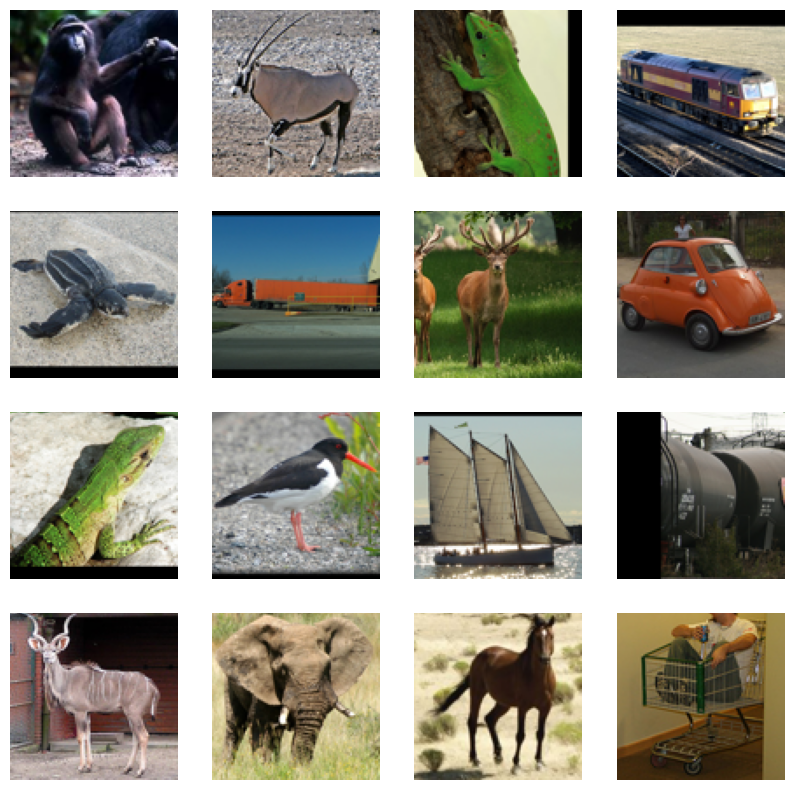

In [10]:
# visualize the first batch
for batch in tf_dataset.take(1):
    visualize_images(batch.numpy())